# Topological analisys of EuroVoc

In [1]:
%load_ext autoreload
%autoreload
import numpy as np
import pandas as pd
import pathlib

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

from pprint import pprint as print
from notebook_utils import *
from taxonomy_metrics import *
from comparative_measures import *
from notebook_draw import *

plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 300
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("whitegrid", {'axes.grid' : False})

# reading the EuroVoc statistics
EUROVOC_DATASET_PATH = pathlib.Path("data/eurovoc-4.9/EVAP49.ttl").resolve()

CS_STATS = pd.read_excel(str(EUROVOC_DATASET_PATH) + "CS_statistics.xlsx")

EV_STATS = CS_STATS[ CS_STATS["name"] == "EuroVoc" ] 
CS_STATS = CS_STATS[ CS_STATS["name"] != "EuroVoc" ] 


In [2]:
# reading (re-creading) the concept scheme graphs, in case some debuging is needed
EUROVOC_DATASET_PATH= pathlib.Path("data/eurovoc-4.9/EVAP49.ttl").resolve()
QUERY_LABELS_RESULTSET_PATH = pathlib.Path("data/eurovoc-4.9/QUERY_LABELS_RESULTSET.csv").resolve()
QUERY_LABELS_RESULTSET = pd.read_csv(QUERY_LABELS_RESULTSET_PATH, delimiter=",")
# greaqting the conceptual graphs
EUROVOC_GRAPH = create_grah_from_eurovoc_label_query(QUERY_LABELS_RESULTSET)
CONCEPT_SCHEME_GRAPHS = create_grah_per_scheme_from_eurovoc_label_query(QUERY_LABELS_RESULTSET)

# Introduction

This document explores and interprets various metrices computed on EuroVoc thesaurus. The anailisys focuses on the hierarchy structure, lexicalisation, cohesion, and other metrics based on the graph structure. 

**Note:** The words *node* (meaning graph node) and *concept* (meaning SKOS concept) will sometimes be used intechangenly in this text but on the second revision they will have to be standardised. The reason for this possible mistaken sinonimity is because the SKOS thesaurus has been reduced to a directed graph. 

**TODO:** explain that structure of the graph. 

The columns in the input data represent various measurements wherease rows stand for concept schemes in EuroVoc on which the measurements were performed. Next I provide the list of metrices and what they mean. For the metrices measured at the level of the graph nodes (e.g. inheritance richness, page rank or lexicalisation) then descriptive indicators are provided such as min/max and average value (combining usually the metric name with the descriptibe indicator, e.g. lexicalisation - min, lexicalisation - mean), while for the metrices that are calculated at the level of the entire graph, single absolute values are given. 

| indicator | description of the graph indicator |
|-----------|-----------|
|nodes| the total number of nodes in the graph|
|top nodes| the number of top nodes (i.e. nodes that have no parents)|
|leaf nodes| the number of leaf nodes (i.e. nodes that have no children)|
|depth| for a node in the graph, it represents the the humber of levels in the taxonomic hierarchy|
|leaf depth| the depth of the leaf nodes i.e. the length of the shortest path hierarchical to the top node |
|inheritance richness| for a node in the hierarchy, it represents the number of direct children connected by a hierarchical relation  |
|inverse inheritance richness| for a node in the hierarchy, it represents the number of direct parents |
|lexicalisation | for a node in the graph, it represents the number of alternative nodes (considered equivalent) connected via lexical relation|
|connectedness| for a node in the graph, it represents the number of orthogonal (i.e. non-hierarchical) relations to other nodes |
|page rank| for a node in the graph, it represents the the importance of that node in the graph provided the assumption tha the more important nodes are more likely to recive more incoming links form other nodes. |
|hubs & authorities| a good hub represented a page that pointed to many other pages, and a good authority represented a page that was linked by many different hubs. See also [HITS algorithm](https://en.wikipedia.org/wiki/HITS_algorithm) |
|eigenvector centrality| eigenvector centrality (also called eigencentrality) is a measure of the influence of a node in a network. |
|degree centrality| the number of links incident upon a node (i.e., the number of ties that a node has) |
|cohesion - strongly connected components| is a sub-graph where there is a path from every node to every other node |
|cohesion - weakly connected components| A weakly connected component is one in which all components are connected by some path, ignoring direction. |
|cohesion - attracting components| An attracting component in a directed graph is a strongly connected component with the property that a random walker on the graph will never leave the component, once it enters the component. |
|cohesion - isolates components| An isolate is a node with no neighbors (that is, with degree zero). For directed graphs, this means no in-neighbors and no out-neighbors. |


In addition, I provide explanation of what the standard descriptive statistics are and how to read them in the table form used below.

| indicator | description |
|-----------|-----------|
| nobs | number of objects in the series|
| minmax | minimum and maximum span|
| mean | the central value of a discrete set of numbers |
| variance | measures how far a set of (random) numbers are spread out from their average value|
| skewness | skewness is a measure of the asymmetry of a distribution about its mean. Any symmetric data should have a skewness near zero. Negative values for the skewness indicate data that are skewed left and positive values for the skewness indicate data that are skewed right.|
| kurtosis | a descriptor of the shape of a probability distribution and is a measure of the "tailedness" of the probability distribution. The kurtosis for a standard normal distribution is three. It can take values between -2 and +inf.|



# Hierarchical structure

The taxonomy hierarchy can be characteriased in terms of the following dimensions: **number of top and leaf nodes, depth of the taxonomy, and inheritance richness**. I first start by providing an overview of these meaurements as value distributions (in the form of hystograms) over entire set of concept schmes. 

,nobs,minmax,mean,variance,skewness,kurtosis
average depth,127,"(0.8552, 2.2692)",1.35,0.08,0.70,0.55
max depth,127,"(1, 5)",2.72,0.50,0.31,0.00


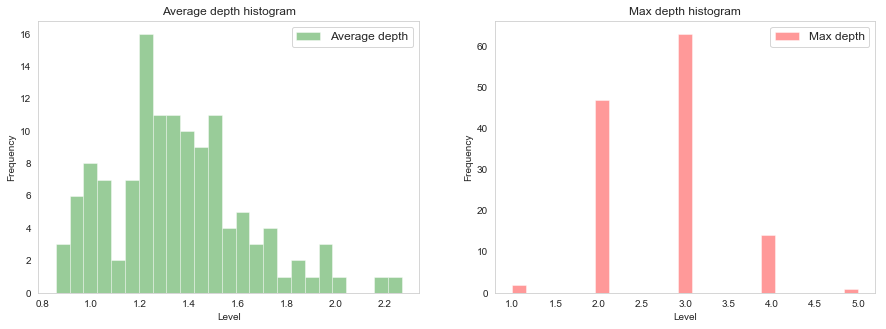

In [3]:
# define the hierarchically relevant metrics
HIERARCHICAL_COLUMNS = ["name","nodes","top nodes","leaf nodes",
                        "depth - max","depth - mean",
                        "inheritance richness - min",
                        "inheritance richness - max",
                        "inheritance richness - mean",
                        "inheritance richness - variance",
                        "inverse inheritance richness - mean",]
h_stats = CS_STATS[HIERARCHICAL_COLUMNS]

# drawing depth
left_plot()
draw_hist(h_stats["depth - mean"],label="Average depth", x_label="Level")
right_plot()
draw_hist(h_stats["depth - max"],label="Max depth", x_label="Level", color="r")

# descriptive statistics 
dsp( describe([h_stats["depth - mean"],h_stats["depth - max"]], ["average depth","max depth"] ) )


In the figure above we can see that most of the concept schemes are on average 1.38 deep reaching up to 5 level. The average depth indicator is quite shallow compared to out expectations. There are no instances of flat lists and there are always at least on level down hierarchy. 

,nobs,minmax,mean,variance,skewness,kurtosis
top nodes,127,"(1, 32)",4.09,12.84,5.37,35.96
leaf nodes,127,"(12, 376)",47.28,"1,513.55",5.31,39.57


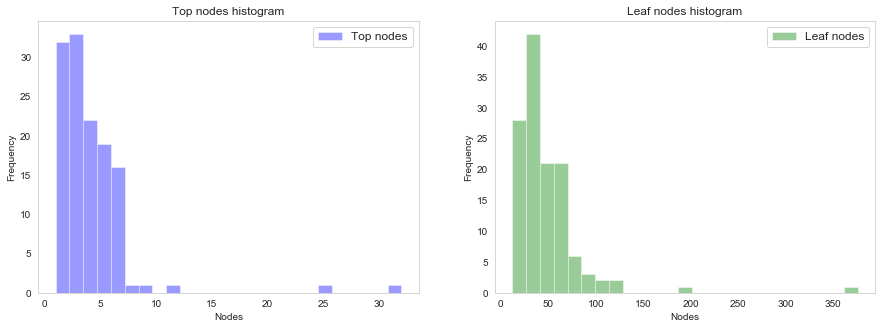

In [4]:
# descriptive statistics for top/leaf nodes
dsp( describe([h_stats["top nodes"],h_stats["leaf nodes"]], ["top nodes"," leaf nodes"] ) )

# drawing top/leaf nodes
left_plot()
draw_hist(h_stats["top nodes"],label="Top nodes", x_label="Nodes", color="b")
right_plot()
draw_hist(h_stats["leaf nodes"],label="Leaf nodes", x_label="Nodes")

The number of top nodes tends to be, as expected, quite small with an anverage of 4.1 per concept scheme; and the average number of leaf nodes 47.3. There are, however some outliers which require attention. 

The exceptions are easy to spot, they are concept schemes belonging to the GEOGRAPHY domain, which represent essentially country groups. Their structure is characterised by shallow and very wide hierarchies which is tipical for group-member or class-cubclass relations. This is contrary to class-subclass relations which tend to be more balanced in depth and in the number of subclasses. 

Below the concept schemes in GEOGRAPHY domain are split from the rest of concept schmes to test the above hypothesis that these concept schemes constitute outliers in the distributions of top and leaf nodes.

,nobs,minmax,mean,variance,skewness,kurtosis
top nodes ALL,127,"(1, 32)",4.09,12.84,5.37,35.96
top nodes NON geo,114,"(1, 9)",3.68,2.64,0.53,0.02
top nodes geo,13,"(1, 32)",7.62,94.92,1.74,1.53


,nobs,minmax,mean,variance,skewness,kurtosis
leaf nodes ALL,127,"(12, 376)",47.28,"1,513.55",5.31,39.57
leaf nodes NON geo,114,"(12, 121)",42.41,453.36,1.11,1.24
leaf nodes geo,13,"(15, 376)",89.92,"9,428.08",2.21,3.97


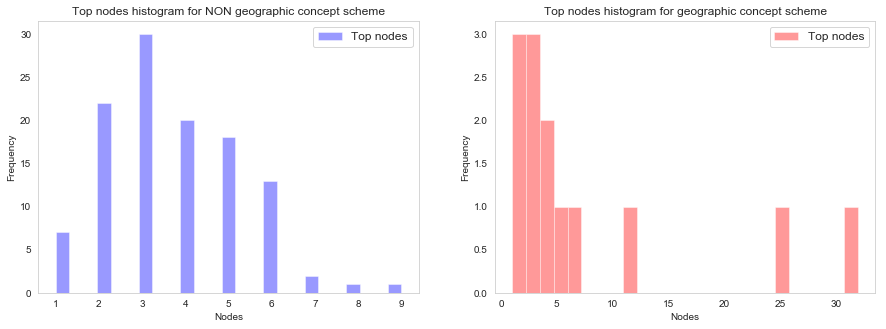

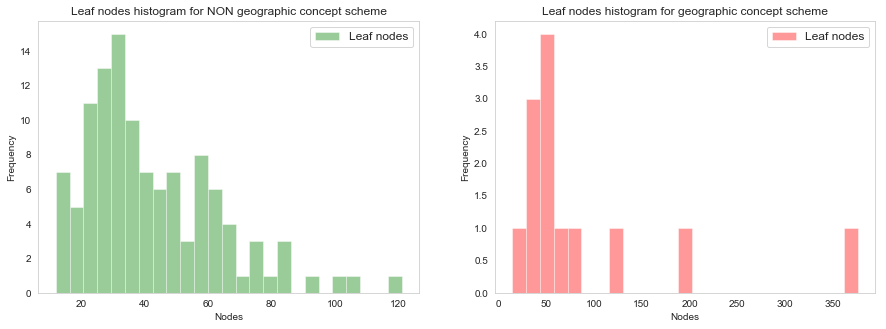

In [5]:
GEOGRAPHY_CS = ["7206 Europe",
                "7211 regions of EU Member States",
                "7216 America",
                "7221 Africa",
                "7226 Asia and Oceania",
                "7231 economic geography",
                "7236 political geography",
                "7241 overseas countries and territories",
                "7606 United Nations",
                "7611 European organisations",
                "7616 extra-European organisations",
                "7621 world organisations",
                "7626 non-governmental organisations",
                ]

h_stats_geo = h_stats[ h_stats["name"].isin(GEOGRAPHY_CS) ]
h_stats_non_geo = h_stats[ ~h_stats["name"].isin(GEOGRAPHY_CS) ]

# compare the geo and non geo concept schemes
left_plot()
draw_hist(h_stats_non_geo["top nodes"],label="Top nodes", x_label="Nodes", 
          title="Top nodes histogram for NON geographic concept scheme", color="b")
right_plot()
draw_hist(h_stats_geo["top nodes"],label="Top nodes", x_label="Nodes", 
          title="Top nodes histogram for geographic concept scheme", color="r")

left_plot()
draw_hist(h_stats_non_geo["leaf nodes"],label="Leaf nodes", x_label="Nodes", 
          title="Leaf nodes histogram for NON geographic concept scheme")
right_plot()
draw_hist(h_stats_geo["leaf nodes"],label="Leaf nodes", x_label="Nodes", 
          title="Leaf nodes histogram for geographic concept scheme", color="r")


# descriptive statistics for top/leaf nodes
dsp( describe([h_stats["top nodes"],h_stats_non_geo["top nodes"], h_stats_geo["top nodes"] ], 
              ["top nodes ALL","top nodes NON geo", "top nodes geo"] ) )
dsp( describe([h_stats["leaf nodes"],h_stats_non_geo["leaf nodes"], h_stats_geo["leaf nodes"] ], 
              ["leaf nodes ALL","leaf nodes NON geo", "leaf nodes geo"] ) )


Above, the left histograms represent distributions of the top and leaf nodes for Eurovoc concept schemes excluding the GEOGRAPHY domain (13 concept schmes); and the right right histograms represent the distribution of top and leaf nodes of the GEOGRAPHY concept schemes only. In each diagram on the left side (all schemes except the geographic ones) the variance reduced significantly and the destribution is less skewd to the right, which means that the distribution is closer now to the normal one with fewer or no outlier (a test is needed). On the other hand, diagrams on the right represent quite sparse distributions that cannot be easely characterised, especially becaiuse there are only 13 data points. 

On average the EuroVoc concept schemes have 3.5 top concepts and 42.4 leaf concepts.

One **recommendation** that can be derived already at this point is that the controlled lists (usually shallow and broad) formed of many instances often participating in multiple groupings, should be managed in a way that makes it clear what is the nature of the concepts and the  meaning of the hierarchical relations employed. Best practices can be adopted from the team managing the content of EU Vocabulaires controlled lists. For example a convention, for such cases, can be that the top/mid concepts are considered as classes or groups and the leaf nodes are always instances (of some sort). In the case of GEOGRAPHY concept schemes this is partially the case. The top/middle concepts represents continents, country groups based on the economic or political membership and the leaf concepts are countries. The type of relations employed are at least of three types: geographical inclusion (e.g. Europe - Romania), group-subgroup (e.g. Arab world - United Arab Emirates or former socialist countries - Eastern bloc countries), and group membership (e.g. Eastern bloc countries - USSR). 

The nodes that are violating the "No single child" policy are provided below. 

In [6]:
n = [ (l,d) for l,d in EUROVOC_GRAPH.nodes(data=True) if d["hierarchical_in"]==1 ]
labels = list(map(lambda x: x[0], n))
print( ", ".join(labels) )

('European Court of Auditors, EPSO, commemoration, EFTA, World Trade '
 'Organisation, European Community, Serbia, UN Environment Programme, African '
 'Union, Andean Community, civil defence, balance of payments assistance, '
 'veterinary medicinal product, social and cultural anthropology, intervention '
 'policy, European Central Bank, Organisation of American States, Turkey, '
 'Ecuador, Ecu, European Trade Union Confederation, Inter-American Development '
 'Bank, Central American Common Market, UN Conference on Trade and '
 'Development, EU budget, religious discrimination, EU production, EU research '
 'policy, EU industrial policy, EU aid, EU loan, air traffic, airport, '
 'airline, aircraft, environmental research, environmental standard, '
 'silviculture, agricultural product, fishing fleet, fishery management, '
 'mollusc, forest conservation, evaluation of resources, stock-exchange '
 'listing, fishing area, freedom of self-determination, local authority '
 'finances, forest

Next, the inheritance richness indicator is analised.

,nobs,minmax,mean,variance,skewness,kurtosis
minimum inheritance richness,114,"(1, 6)",1.18,0.43,4.81,27.06


,nobs,minmax,mean,variance,skewness,kurtosis
average inheritance richness,114,"(2.5, 9.5)",4.71,1.94,1.02,0.84


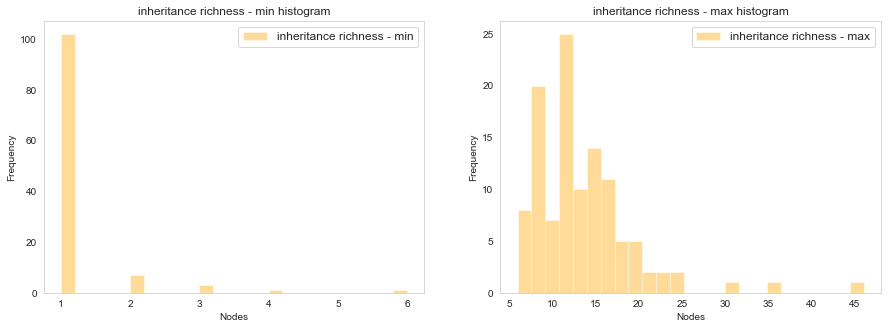

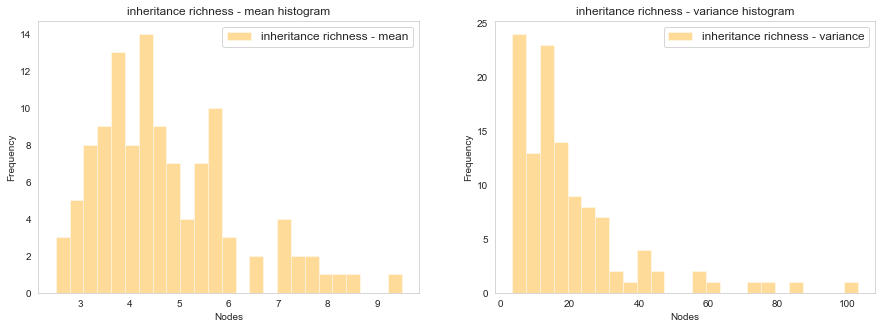

In [7]:
# "inheritance richness - min"
# "inheritance richness - max"
# "inheritance richness - mean"
# "inheritance richness - variance"
# "inverse inheritance richness - mean"
                
left_plot()
draw_hist(h_stats_non_geo["inheritance richness - min"],label="inheritance richness - min", x_label="Nodes", color="orange")
right_plot()
draw_hist(h_stats_non_geo["inheritance richness - max"],label="inheritance richness - max", x_label="Nodes", color="orange")
left_plot()
draw_hist(h_stats_non_geo["inheritance richness - mean"],label="inheritance richness - mean", x_label="Nodes", color="orange")
right_plot()
draw_hist(h_stats_non_geo["inheritance richness - variance"],label="inheritance richness - variance", x_label="Nodes", color="orange")

dsp( describe([h_stats_non_geo["inheritance richness - min"],], 
              ["minimum inheritance richness"]))
dsp( describe([h_stats_non_geo["inheritance richness - mean"],], 
              ["average inheritance richness"]))


Having only one child, i.e. **minimum inheritance richness** one, is a conceptual mistake and should be avoided. In general, a narrower concept is created in order to restrict the scope and provide another concept with more specific meaning. Examples of operations that lead to restriction of concept scope are: specialisation, reduction in abstraction, decomposition, exemplification etc. In any case the result should consist of at least two subsconcepts, otherwise, if only one is provided then the narrower concept has the same scope as the parent which is wrong. 

**Recommendation** find all instances where a concept has only one child subconcept and edit the hierarchical relation(s) to resolve the situation. Some possible edits are: (a) either add at least one more sibling sub-concept to discriminate among them (b) raise the subconcept it to the level of the parent (i.e. make it a direct child to its current grandparent) or other form of resolution as the context dictates.  

In a taxonomy the number of children varies form one node to another. Question is, what are the reasonable limits for such variation. Moreover provided some average inheritance richness, to what degree deviations from that average are acceptable. One possible source of problems might be high variance. 

The list of concept schemes with highest inheritance richness vaiance are provided below.


In [8]:
ih_variance = h_stats_non_geo.sort_values(by="inheritance richness - variance",ascending=False)  
dsp( ih_variance[["name", "inheritance richness - variance"]][:10] )

,name,inheritance richness - variance
4,0811 cooperation policy,103.28
6,2431 insurance,86.33
7,1006 EU institutions and European civil service,78.08
8,3221 documentation,74.53
9,"6816 iron, steel and other metal industries",62.29
10,0406 political framework,57.16
11,3206 education,56.67
12,4411 labour market,47.29
13,0411 political party,46.67
15,5216 deterioration of the environment,41.07


In [9]:
# target_cs_name = "7236 political geography"
# t_cs = [ g for n,g in CONCEPT_SCHEME_GRAPHS if n==target_cs_name]
# graph = t_cs[0]

# # pos = nx.spring_layout(graph)
# draw_graph(graph,)
# # graph.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
# # graph.draw()

In [10]:
# h_stats.plot(kind='scatter',x='inheritance richness - mean',y='leaf nodes',color='b')
# plt.title("Inheritance richness and number of leaf nodes scatter plot")
# plt.xlabel("Average inheritance richness")
# plt.ylabel("Number of leaf nodes")

# h_stats.plot(kind='scatter',x='inheritance richness - mean',y='top nodes',color='b')
# plt.title("Inheritance richness and number of top nodes scatter plot")
# plt.xlabel("Average inheritance richness")
# plt.ylabel("Number of top nodes")

# h_stats.plot(kind='scatter',x='top nodes',y='leaf nodes',color='b')
# plt.title("Number of top and leaf nodes scatter plot")
# plt.xlabel("Number of top nodes")
# plt.ylabel("Number of leaf nodes")

# h_stats_non_geo.plot(kind='scatter',x='top nodes',y='leaf nodes',color='b')
# plt.title("Number of top and leaf nodes scatter plot")
# plt.xlabel("Number of top nodes")
# plt.ylabel("Number of leaf nodes")

# h_stats.plot(kind='scatter',x='depth - mean',y='top nodes',color='b')
